In [34]:
import matplotlib
matplotlib.use('TkAgg')
import numpy as np
import pandas as pd
from pandas import Series,DataFrame
import matplotlib.pyplot as plt

In [1]:
%matplotlib inline

In [35]:
#株価データをdatagetのダウンロードファイルから読み込み、pandasのデータフレームにするクラスを作る
#20160425追記 5分足の処理にバグあり。最後の時間のデータがNanだと全体がNanになっている。
#5分足を作ってもよいかもしれないな。。
#どうも5分足のルールは、始まりの瞬間はその時間つまり9時と12時半は5分集計でなく、瞬間集計?で、あとは5分集計になっているようだ。
#しかしこれはちゃんと確認は必要
#まあ一回やってみるか
import matplotlib
matplotlib.use('TkAgg')
import numpy as np
import pandas as pd
from pandas import Series,DataFrame
import matplotlib.pyplot as plt


class GetPriceFrom1dayDatas():
    '1日分の1分足の集合体データから任意の銘柄の株価を取得する'
    def __init__(self, filename):
        #後で使用するインスタンス変数を設定
        self.index = None

        with open(filename, 'r',encoding='EUC-JP') as a_file:
            fr = a_file.readlines()
        self.date = fr[0].split('\t')[0] #日付の取得
        #各銘柄のヘッダー情報と、株価情報にわける。さらに株価情報は時間と、4本値と出来高を分ける。
        #ヘッダー情報はそこから銘柄コードとデータ数と小数点数に分ける
        #一列のデータが7個と4本値のデータが1個になる。あとは日付か。
        self.header = []
        self.time_series = []
        self.four_values_lis = []
        self.volume_lis = []
        self.time_lis = []
        
        n = np.nan
        def f(x): #これしたの関数とかぶっているな。直そう
            if x == '-':
                return np.nan
            else:
                return int(x)

        for i in fr[1:]: #日付のデータを除いてる
            split = i.split('\t')
            self.header.append(split[:3]) #最初の3つのデータは、銘柄コード・データ本数・小数点
            p = split[3:] #それ以降が、時間と4本値と出来高の6セットが9時から15時まで続くデータ
            self.time_lis.append(p[::6][:-1])
            ary = range(len(p))
            four_values = [p[x] for x in ary if  (x % 6 != 0) and (x % 6 != 5)] #時間と出来高を除く
            four_values =np.array(list(map(self.hyphen2npn,four_values))) #欠損値をnp.nanにして、価格をintにする
            self.four_values_lis.append(four_values)
        #     four_values_lis = np.append(four_values_lis, four_values)
            volume = [p[x] for x in ary if x % 6 == 5]
            volume =np.array(list(map(self.hyphen2npn,volume)))  #欠損値をnp.nanにして、volumeを数値にしているのかな？listなにしてるの・・・
            self.volume_lis.append(volume) 

        #ヘッダーから銘柄コードと、データ数と、小数点を抽出
        self.stock_code_lis = [x[0] for x in self.header]
        self.stock_code_lis = [int(x) for x in self.stock_code_lis] #文字列から整数型にしておく
        self.data_num_lis = [int(x[1]) for x in self.header]
        self.decimal_lis = [int(x[2]) for x in self.header]

        
    def hyphen2npn(self, x):
        if x == '-':
            return np.nan
        else:
            return int(x)
    #銘柄コードを入れると、indexを返す関数。indexとはdatagetが提供しているファイルの中でのデータ順番
    def get_index(self, stock_code):
        try:
            self.index = self.stock_code_lis.index(stock_code)
            return self.index
        except:
            #ここでもっと普遍的なエラーを発生させたほうがよいな。
            print('Your code is not in the list.')
            raise #これをいれると、エラーを呼び出した関数に渡すことができる
    #銘柄コードを入れると、時刻データを取得
    def get_time_series(self, stock_code):
        try:
            t = self.time_lis[self.get_index(stock_code)] #これだとエラーを吐き出せない？？get_indexにraiseをつければ大丈夫
            t = [self.date + x for x in t] #日付を付け足しておく。dateは一番最初に取得してある日付。
            dt = pd.to_datetime(t) #pandasのtimestampオブジェクトに変換する
            return dt
        except:
            print('Error!')
    #銘柄コードを入れると、出来高を取得
    def get_volume(self, stock_code):
        try:
            volume = self.volume_lis[self.get_index(stock_code)]
            #時系列の取得
            time_stamps = self.get_time_series(stock_code)
            #pandasデータフレームに変換する
            df = pd.DataFrame(volume, index=time_stamps, columns=['volume'])
            #出来高が積算になっているので差分をとっておく
            v = df.values.flatten()
            vd = np.append(v[0], v[1:] - v[:-1])
            vdf = DataFrame(vd, index = df.index, columns=['volume'])
            return vdf
        except:
            print('Error!')

    def get_four_prices(self, stock_code):
        try:
            self.index = self.get_index(stock_code)
            data_num = self.data_num_lis[self.index]
            #小数点合わせる #厳密にやるならdecimalを使う必要があるが、、numpyでは扱えないのでやめる
            #だから差分を比較するとかするときは注意が必要！地雷になりませんように。。
            four_prices = self.four_values_lis[self.index] /10**self.decimal_lis[self.index]
            #2次元配列に変える
            four_prices.shape = (four_prices.size//4, 4)
            #時系列の取得
            time_stamps = self.get_time_series(stock_code)
            #pandasデータフレームに変換する
            df = pd.DataFrame(four_prices, index=time_stamps, columns=['open','high','low','close'])
            if len(df) == data_num: #データの数が合っているかチェックする
                return df
            else:
                return print('data_num error')
        except:
            print('Error')

    def get_four_prices_volume(self, stock_code):
        price_df = self.get_four_prices(stock_code)
        volume_df = self.get_volume(stock_code)
        df = pd.concat([price_df, volume_df], axis=1)
        return df
    
    def get_four_prices_volume_5min(self,stock_code):
        #1分足のデータフレームを取得する
        min1_df = self.get_four_prices_volume(stock_code)
        #午前の終わりの11:30を特定する
        t1130 = pd.to_datetime(self.date + '1130')
        time_series = min1_df.index
        t1130_index, = time_series.indexer_at_time(t1130) #1130のindexを特定.カンマはarrayから取り出している
        #午後の引けを特定する.こっちは最後のデータのindexを探す
        tClosed_index, = time_series.indexer_at_time(time_series[-1])
        #午前と午後にわける
        min1_dfam = min1_df.iloc[:t1130_index+1]
        min1_dfpm = min1_df.iloc[t1130_index+1:]
        #始値と終値を出す処理用関数
        def detect_openclose_price(price_list):
            '''価格のリストのデータを入れて始値と終値を返す'''
            for  i in price_list:
                if np.isnan(i):
                    price = np.nan
                else:
                    return i
                    break
                return price
        #午前と午後の処理をする
        def min5(df):
            #始値,終値,高値,安値,出来高を取得する
            op, cl, hi, lo, vo = df['open'], df['close'],df['high'], df['low'], df['volume'] # データ型がseriesになる
            #まず時間を作る。午前と午後の引けだけ特別扱いする
            time_index = op.index[::5] #これで特別扱いしていることなっている。0始まりだから。
            #始値と終値を作る処理をする
            #マルチターゲット代入というらしい
            oplis = cllis = hilis = lolis = volis = np.array([])
            
            for i in np.arange(0,len(df)-1, 5): #引けのデータは別扱いにするために、-1をする
                #もし15時3分だったらどうするのか？エラーになる。。それいかんな。tryを使おう。
                #close priceはリストを逆順にしたらよい
                #np.nanがあるときの扱いを変える必要がある
                p = detect_openclose_price(op[i:i + 5])
                oplis = np.append(oplis, p)
                p = detect_openclose_price(cl[i:i + 5][::-1]) #リストを逆にして入れる
                cllis = np.append(cllis, p)

                p = np.nanmax(hi[i:i + 5].values) 
                hilis = np.append(hilis, p)
                p = np.nanmin(lo[i:i + 5].values)
                lolis= np.append(lolis, p)
                
                v = vo[i:i + 5].values.sum() 
                volis = np.append(volis, v)

            #dataframeに直す
            t = np.array([oplis, hilis, lolis, cllis,volis])
            df1 = DataFrame(t.T, index = time_index[:-1],columns=['open','high','low','close','volume'])
            df2 = df.tail(1)
            df3 = pd.concat([df1, df2])
            return df3
        #午前と午後を処理して結合して返す
        return pd.concat([min5(min1_dfam), min5(min1_dfpm)])
    
    def plot_5min(self,stock_code):
        '''5分足のチャートをプロットする'''
        import matplotlib.dates as md
        import datetime
        import matplotlib.pyplot as plt
        from matplotlib.dates import DateFormatter
        from matplotlib.finance import candlestick_ohlc
        import matplotlib.ticker as mticker

        df_name = self.get_four_prices_volume_5min(stock_code)

        pytime = [x.to_datetime() for x in df_name.index]
        mpltime = [md.date2num(x) for x in pytime]
        #次にohlc形式のリストを作ろう
        ohlc = [(t, v[0],v[1],v[2],v[3]) for t, v in zip(mpltime, df_name.values)]

        # dayFormatter = DateFormatter('%d')      # e.g., 12

        # fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,12), sharex=True)
        fig = plt.figure(figsize=(10,8))
        #サイズを調整できる 表示位置と比は(left, bottom, width, height)のように指定できます。
        ax1 = fig.add_axes((0, 0.25, 1, 0.7))
        ax2 = fig.add_axes((0, 0, 1, 0.2), sharex=ax1) #x軸をshareしている

        # ax1 = fig.add_subplot(211)
        # ax2 = fig.add_subplot(212, sharex = ax1)

        # fig.subplots_adjust(bottom=0.2)

        #昼休みをスキップするようなlocator必要かも。
        # minute = md.MinuteLocator()
        hour = md.HourLocator()
        ax1.xaxis.set_major_locator(hour)
        # ax.xaxis.set_major_locator(mticker.MaxNLocator(15))
        #30分のラインも引きたいところだ.
        #x軸の範囲はどうきめるのだろうか？
        #引き渡してる値を使うのかも→その通り
        #mpltimeを使って操作する
        # ax.set_xlim( 736018.3819444445, 736018.625)

        dayFormatter = md.DateFormatter('%H:%M')
        ax1.xaxis.set_major_formatter(dayFormatter)

        ax1.grid(True)

        #ローソク足チャートを描画する
        #太さを自動調整するように関数必要かもしれないな。
        candlestick_ohlc(ax1, ohlc,width=0.0025,colorup='cornflowerblue', colordown='midnightblue')

        ax1.xaxis.set_major_locator(hour)

        dayFormatter = md.DateFormatter('%H:%M')
        ax1.xaxis.set_major_formatter(dayFormatter)

        ax1.grid(True)

        ax2.bar(mpltime, df_name['volume'].values,width = 0.0025, color = 'darkslateblue', edgecolor='none')
        ax2.xaxis.set_major_locator(hour)
        ax2.xaxis.set_major_formatter(dayFormatter)
        ax2.grid(True)


        # ax.xaxis_date()
        # ax.autoscale_view()
        # plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
        # plt.xlabel('Hour')
        # plt.ylabel('Price')
        # plt.title('ohlc chart')

        plt.show()        



In [49]:
#今ある株価データのpickleデータをつくる
path = '/Users/prokapi/iPythonNotebook_file/株価データ/'
fname = '2016*min*s.txt'
import glob
flist = glob.glob(path+fname)

In [56]:
fname_ls = []
for f in flist:
    date = f.split('/')[-1].split('_')[0]
    fname = 'min_{}_s.pickle'.format(date)
    fname_ls.append(fname)

In [57]:
fname_ls

['min_20160223_s.pickle',
 'min_20160224_s.pickle',
 'min_20160225_s.pickle',
 'min_20160226_s.pickle',
 'min_20160229_s.pickle',
 'min_20160301_s.pickle',
 'min_20160302_s.pickle',
 'min_20160303_s.pickle',
 'min_20160304_s.pickle',
 'min_20160307_s.pickle',
 'min_20160308_s.pickle',
 'min_20160309_s.pickle',
 'min_20160310_s.pickle',
 'min_20160311_s.pickle',
 'min_20160314_s.pickle',
 'min_20160315_s.pickle',
 'min_20160316_s.pickle',
 'min_20160317_s.pickle',
 'min_20160318_s.pickle']

In [58]:
for pname, fname in zip(fname_ls,flist):
    df = GetPriceFrom1dayDatas(fname)
    with open(pname, 'wb') as f:
        pickle.dump(df, f) 

In [36]:
filename = '/Users/prokapi/iPythonNotebook_file/株価データ/20160224_min20160224s.txt'
d20160224 = GetPriceFrom1dayDatas(filename)

In [14]:
d20160224.get_index(7203)

1989

In [15]:
d20160224.get_time_series(7203)

DatetimeIndex(['2016-02-24 09:00:00', '2016-02-24 09:01:00',
               '2016-02-24 09:02:00', '2016-02-24 09:03:00',
               '2016-02-24 09:04:00', '2016-02-24 09:05:00',
               '2016-02-24 09:06:00', '2016-02-24 09:07:00',
               '2016-02-24 09:08:00', '2016-02-24 09:09:00',
               ...
               '2016-02-24 14:51:00', '2016-02-24 14:52:00',
               '2016-02-24 14:53:00', '2016-02-24 14:54:00',
               '2016-02-24 14:55:00', '2016-02-24 14:56:00',
               '2016-02-24 14:57:00', '2016-02-24 14:58:00',
               '2016-02-24 14:59:00', '2016-02-24 15:00:00'],
              dtype='datetime64[ns]', length=302, freq=None)

In [17]:
d20160224.get_volume(7203).head()

,volume
2016-02-24 09:00:00,700300
2016-02-24 09:01:00,50300
2016-02-24 09:02:00,157000
2016-02-24 09:03:00,55400
2016-02-24 09:04:00,29400


In [30]:
df7203 = d20160224.get_four_prices_volume_5min(7203) #トヨタ
df7751 = d20160224.get_four_prices_volume_5min(7751) #キヤノン
df8411 = d20160224.get_four_prices_volume_5min(8411) #みずほ
type(df7203)

pandas.core.frame.DataFrame

pickleを使って、オブジェクトをそのまま保存する。  
株価のデータはpandasのdataframeで保存してある


In [ ]:
pickleで日付のデータを保存しておく

In [40]:
import pickle
with open(' d20160224.pickle', 'wb') as f:
    pickle.dump(d20160224, f) 

In [41]:
import pickle
with open('d20160224.pickle', 'rb') as f:
    pictest = pickle.load(f)

In [44]:
pictest.plot_5min(7201)

In [33]:
import pickle

with open('20160224_7203.pickle', 'wb') as f:
    pickle.dump(df7203, f) 

In [34]:
with open('20160224_7751.pickle', 'wb') as f:
    pickle.dump(df7751, f) 

In [35]:
with open('20160224_8411.pickle', 'wb') as f:
    pickle.dump(df8411, f) 

In [4]:
path = '/Users/prokapi/iPythonNotebook_file/app_summary_introduction/df7203.pickle'
import pickle
with open(path, 'rb') as f:
    pictest = pickle.load(f)

In [24]:
#パスの中に条件に合うファイルがあるかどうかを確かめる
import glob
date = '20160224'
path = '/Users/prokapi/iPythonNotebook_file/app_summary_introduction/{}_*.pickle'.format(date)
ls = glob.glob(path)

In [25]:
ls

['/Users/prokapi/iPythonNotebook_file/app_summary_introduction/20160224_7203.pickle',
 '/Users/prokapi/iPythonNotebook_file/app_summary_introduction/20160224_7751.pickle',
 '/Users/prokapi/iPythonNotebook_file/app_summary_introduction/20160224_8411.pickle']

In [26]:
f = ls[0]

In [29]:
g = f.split('/')[-1]

In [32]:
f.split('/')[-1].split('.')[0].split('_')[-1]

'7203'

In [54]:
if len(ls) !=0:
    print('t')
else:
    print('n')

t


In [5]:
pictest.head()

,open,high,low,close,volume
2016-02-24 09:00:00,5900,5919,5873,5889,992400
2016-02-24 09:05:00,5889,5889,5835,5850,726600
2016-02-24 09:10:00,5848,5878,5841,5868,208400
2016-02-24 09:15:00,5869,5875,5855,5861,228900
2016-02-24 09:20:00,5862,5868,5852,5856,194700


In [82]:
#これをグラフにする
def ohlc_plot(df_name):
    '''5分足のチャートをプロットする'''
    import matplotlib.dates as md
    import datetime
    import matplotlib.pyplot as plt
    from matplotlib.dates import DateFormatter
    from matplotlib.finance import candlestick_ohlc
    import matplotlib.ticker as mticker

    pytime = [x.to_datetime() for x in df_name.index]
    mpltime = [md.date2num(x) for x in pytime]
    #次にohlc形式のリストを作ろう
    ohlc = [(t, v[0],v[1],v[2],v[3]) for t, v in zip(mpltime, df_name.values)]

    # dayFormatter = DateFormatter('%d')      # e.g., 12

    # fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,12), sharex=True)
    fig = plt.figure(figsize=(4,3))
    #サイズを調整できる 表示位置と比は(left, bottom, width, height)のように指定できます。
    ax1 = fig.add_axes((0, 0.3, 1, 0.62))
    ax2 = fig.add_axes((0, 0, 1, 0.2), sharex=ax1) #x軸をshareしている

    # ax1 = fig.add_subplot(211)
    # ax2 = fig.add_subplot(212, sharex = ax1)

    # fig.subplots_adjust(bottom=0.2)

    #昼休みをスキップするようなlocator必要かも。
    # minute = md.MinuteLocator()
    hour = md.HourLocator()
    ax1.xaxis.set_major_locator(hour)
    # ax.xaxis.set_major_locator(mticker.MaxNLocator(15))
    #30分のラインも引きたいところだ.
    #x軸の範囲はどうきめるのだろうか？
    #引き渡してる値を使うのかも→その通り
    #mpltimeを使って操作する
    # ax.set_xlim( 736018.3819444445, 736018.625)

    dayFormatter = md.DateFormatter('%H:%M')
    ax1.xaxis.set_major_formatter(dayFormatter)

    ax1.grid(True)

    #ローソク足チャートを描画する
    #太さを自動調整するように関数必要かもしれないな。
    candlestick_ohlc(ax1, ohlc,width=0.0025,colorup='cornflowerblue', colordown='midnightblue')

    ax1.xaxis.set_major_locator(hour)

    dayFormatter = md.DateFormatter('%H:%M')
    ax1.xaxis.set_major_formatter(dayFormatter)

    ax1.grid(True)
    ax1.tick_params(labelsize='small' )

    ax2.bar(mpltime, df_name['volume'].values,width = 0.0025, color = 'darkslateblue', edgecolor='none')
    ax2.xaxis.set_major_locator(hour)
    ax2.xaxis.set_major_formatter(dayFormatter)
    ax2.tick_params(labelsize='small' )
    ax2.grid(True)


    # ax.xaxis_date()
    # ax.autoscale_view()
    # plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
    # plt.xlabel('Hour')
    # plt.ylabel('Price')
    # plt.title('ohlc chart')

    plt.show()        

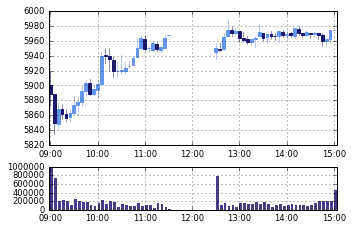

In [83]:
ohlc_plot(pictest)

In [22]:
#tkFrameの中で表示させる
def tk_ohlc_plot(df_name, tkFrame):
    '''5分足のチャートをプロットする'''
    import matplotlib
    matplotlib.use('TkAgg')
    import tkinter as tk
    import numpy as np
    from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
    from matplotlib.figure import Figure

    import matplotlib.dates as md
    import datetime
    import matplotlib.pyplot as plt
    from matplotlib.dates import DateFormatter
    from matplotlib.finance import candlestick_ohlc
    import matplotlib.ticker as mticker
    


    pytime = [x.to_datetime() for x in df_name.index]
    mpltime = [md.date2num(x) for x in pytime]
    #次にohlc形式のリストを作ろう
    ohlc = [(t, v[0],v[1],v[2],v[3]) for t, v in zip(mpltime, df_name.values)]

    # dayFormatter = DateFormatter('%d')      # e.g., 12

    # fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,12), sharex=True)
    fig = Figure(figsize=(4, 3))
    #サイズを調整できる 表示位置と比は(left, bottom, width, height)のように指定できます。
    ax1 = fig.add_axes((0.13, 0.35, 0.77, 0.55))
    ax2 = fig.add_axes((0.13, 0.1, 0.77, 0.17), sharex=ax1) #x軸をshareしている

    # ax1 = fig.add_subplot(211)
    # ax2 = fig.add_subplot(212, sharex = ax1)

    # fig.subplots_adjust(bottom=0.2)

    #昼休みをスキップするようなlocator必要かも。
    # minute = md.MinuteLocator()
    hour = md.HourLocator()
    ax1.xaxis.set_major_locator(hour)
    # ax.xaxis.set_major_locator(mticker.MaxNLocator(15))
    #30分のラインも引きたいところだ.
    #x軸の範囲はどうきめるのだろうか？
    #引き渡してる値を使うのかも→その通り
    #mpltimeを使って操作する
    # ax.set_xlim( 736018.3819444445, 736018.625)

    dayFormatter = md.DateFormatter('%H:%M')
    ax1.xaxis.set_major_formatter(dayFormatter)

    ax1.grid(True)

    #ローソク足チャートを描画する
    #太さを自動調整するように関数必要かもしれないな。
    candlestick_ohlc(ax1, ohlc,width=0.0025,colorup='cornflowerblue', colordown='midnightblue')

    ax1.xaxis.set_major_locator(hour)

    dayFormatter = md.DateFormatter('%H:%M')
    ax1.xaxis.set_major_formatter(dayFormatter)

    ax1.grid(True)
    ax1.tick_params(labelsize='small' )

    ax2.bar(mpltime, df_name['volume'].values,width = 0.0025, color = 'darkslateblue', edgecolor='none')
    ax2.xaxis.set_major_locator(hour)
    ax2.xaxis.set_major_formatter(dayFormatter)
    ax2.tick_params(labelsize='small' )
    ax2.grid(True) 
    
    canvas = FigureCanvasTkAgg(fig, tkFrame)
    canvas.show()
    canvas._tkcanvas.pack(side=tk.TOP, fill=tk.BOTH, expand=1)

In [23]:
import tkinter as tk
root = tk.Tk()
gf = tk.Frame(root)
gf.pack(fill=tk.BOTH, expand=1)

tk_ohlc_plot(pictest, gf)

gf.mainloop()

In [84]:
import tkinter as tk
import matplotlib
matplotlib.use('TkAgg')
import numpy as np
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.figure import Figure


root = tk.Tk()
gf = tk.Frame(root)
gf.pack()

f = Figure(figsize=(5, 3), dpi=100)
a = f.add_subplot(111)
#適当なデータをつくる    
a.plot(np.random.randn(100))
canvas = FigureCanvasTkAgg(f, gf)
canvas.show()
canvas._tkcanvas.pack(side=tk.TOP, fill=tk.BOTH, expand=1)
#ボタンをつける.bindなら引数とれるのか？

gf.mainloop()

/Users/prokapi/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [42]:
os.path.isfile('20160224_7203.pickle')

True

In [38]:
os.getcwd()

'/Users/prokapi/iPythonNotebook_file/app_summary_introduction'

In [26]:
df8227_1min = d20160224.get_four_prices_volume(8227) #ワールド


In [27]:
df8227_1min

,open,high,low,close,volume
2016-02-24 09:00:00,12040,12080,12010,12050,10000
2016-02-24 09:01:00,12040,12040,12040,12040,200
2016-02-24 09:02:00,12050,12050,12030,12030,800
2016-02-24 09:03:00,12040,12060,12040,12060,300
2016-02-24 09:04:00,12070,12070,12070,12070,100
2016-02-24 09:05:00,12060,12060,11980,11990,4100
2016-02-24 09:06:00,12010,12070,12010,12070,5200
2016-02-24 09:07:00,12090,12120,12090,12120,1900
2016-02-24 09:08:00,12130,12140,12130,12140,1000
2016-02-24 09:09:00,12130,12130,12080,12090,2300


In [31]:
df8411

,open,high,low,close,volume
2016-02-24 09:00:00,164.6,164.6,163.3,163.9,15754200
2016-02-24 09:05:00,163.9,164.0,163.0,163.2,7061300
2016-02-24 09:10:00,163.2,163.6,162.8,163.1,3929200
2016-02-24 09:15:00,163.2,164.3,163.0,163.8,3336900
2016-02-24 09:20:00,163.8,164.1,163.3,163.8,2605700
2016-02-24 09:25:00,163.8,164.1,163.6,164.1,1214300
2016-02-24 09:30:00,164.0,164.5,163.9,164.4,1775900
2016-02-24 09:35:00,164.3,164.7,163.8,164.4,3178700
2016-02-24 09:40:00,164.4,165.4,164.3,165.2,3096200
2016-02-24 09:45:00,165.1,165.7,164.7,165.5,2474900


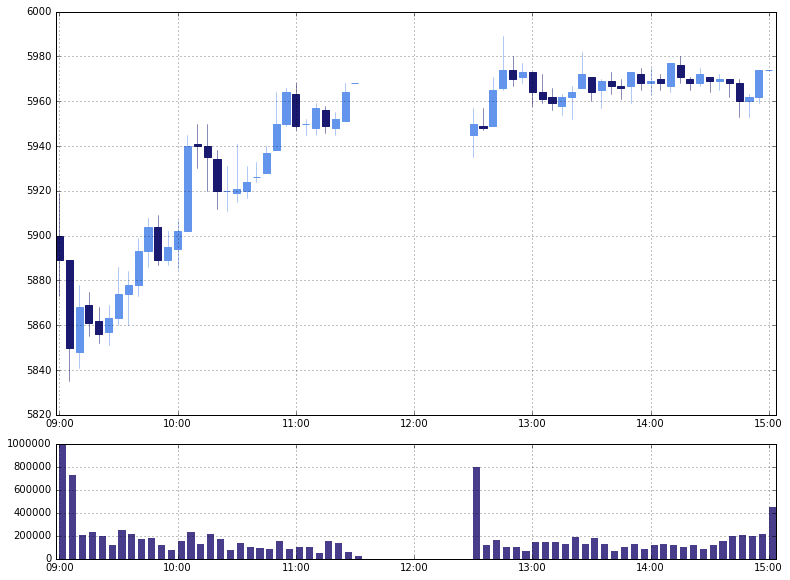

In [18]:
d20160224.plot_5min(7203)

In [11]:
toyota5min = d20160224.get_four_prices_volume_5min(7203)

Error!


NameError: name 'min_df' is not defined

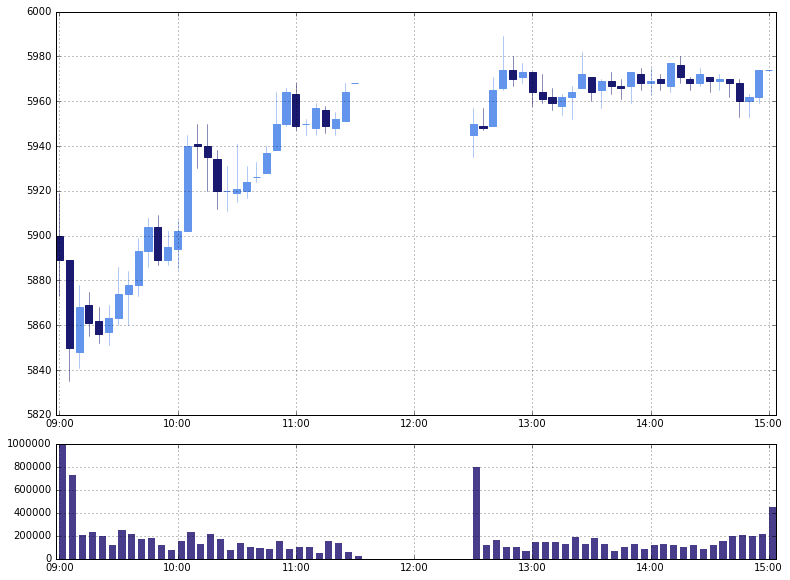

In [549]:
d20160224.plot_5min(7203)

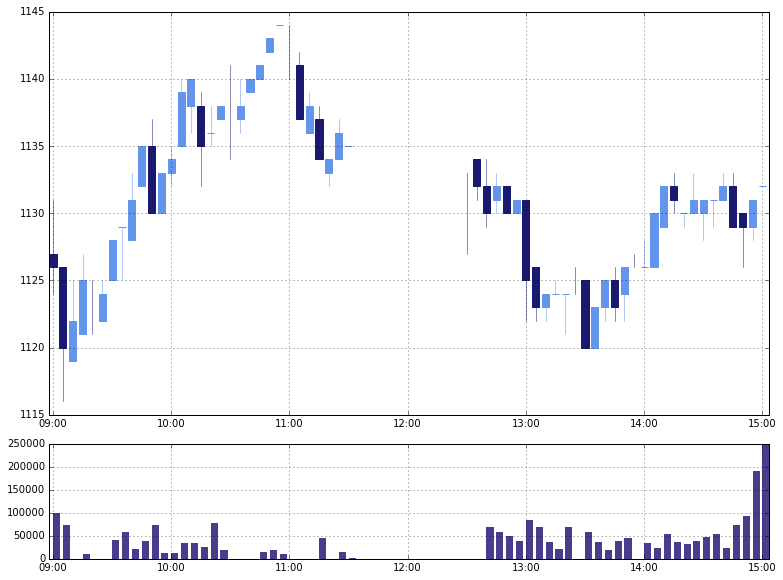

In [550]:
d20160224.plot_5min(7752)

In [1]:
import matplotlib
matplotlib.use('TkAgg')

import numpy as np
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
# implement the default mpl key bindings
from matplotlib.backend_bases import key_press_handler

from matplotlib.figure import Figure
import tkinter as tk

import matplotlib.dates as md
import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from matplotlib.finance import candlestick_ohlc
import matplotlib.ticker as mticker

df_name = canon5min

pytime = [x.to_datetime() for x in df_name.index]
mpltime = [md.date2num(x) for x in pytime]
#次にohlc形式のリストを作ろう
ohlc = [(t, v[0],v[1],v[2],v[3]) for t, v in zip(mpltime, df_name.values)]

# dayFormatter = DateFormatter('%d')      # e.g., 12

# fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,12), sharex=True)
fig = plt.figure(figsize=(10,8))

ax1 = fig.add_axes((0, 0.25, 1, 0.7))
ax2 = fig.add_axes((0, 0, 1, 0.2), sharex=ax1)

# ax1 = fig.add_subplot(211)
# ax2 = fig.add_subplot(212, sharex = ax1)

# fig.subplots_adjust(bottom=0.2)

#昼休みをスキップするようなlocator必要かも。
# minute = md.MinuteLocator()
hour = md.HourLocator()
ax1.xaxis.set_major_locator(hour)
# ax.xaxis.set_major_locator(mticker.MaxNLocator(15))
#30分のラインも引きたいところだ.
#x軸の範囲はどうきめるのだろうか？
#引き渡してる値を使うのかも→その通り
#mpltimeを使って操作する
# ax.set_xlim( 736018.3819444445, 736018.625)

dayFormatter = md.DateFormatter('%H:%M')
ax1.xaxis.set_major_formatter(dayFormatter)

ax1.grid(True)

#ローソク足チャートを描画する
#太さを自動調整するように関数必要かもしれないな。
candlestick_ohlc(ax1, ohlc,width=0.0025,colorup='cornflowerblue', colordown='midnightblue')

ax1.xaxis.set_major_locator(hour)

dayFormatter = md.DateFormatter('%H:%M')
ax1.xaxis.set_major_formatter(dayFormatter)

ax1.grid(True)

ax2.bar(mpltime, df_name['volume'].values,width = 0.0025, color = 'darkslateblue', edgecolor='none')
ax2.xaxis.set_major_locator(hour)
ax2.xaxis.set_major_formatter(dayFormatter)
ax2.grid(True)

root = tk.Tk()
root.wm_title("Embedding in TK")

canvas = FigureCanvasTkAgg(fig, master=root)
canvas.show()
canvas._tkcanvas.pack(side=tk.TOP, fill=tk.BOTH, expand=1)

root.mainloop()

NameError: name 'canon5min' is not defined

In [488]:
toyota5min = d20160224.get_four_prices_volume_5min(7203)

In [537]:
canon5min  = d20160224.get_four_prices_volume_5min(7751)

In [539]:
ricoh5min = d20160224.get_four_prices_volume_5min(7752)

In [490]:
toyota5min.tail()

,open,high,low,close,volume
2016-02-24 14:40:00,5970,5970,5962,5968,194900
2016-02-24 14:45:00,5968,5970,5953,5960,208000
2016-02-24 14:50:00,5960,5963,5953,5962,196300
2016-02-24 14:55:00,5962,5974,5959,5974,214200
2016-02-24 15:00:00,5974,5974,5974,5974,449000


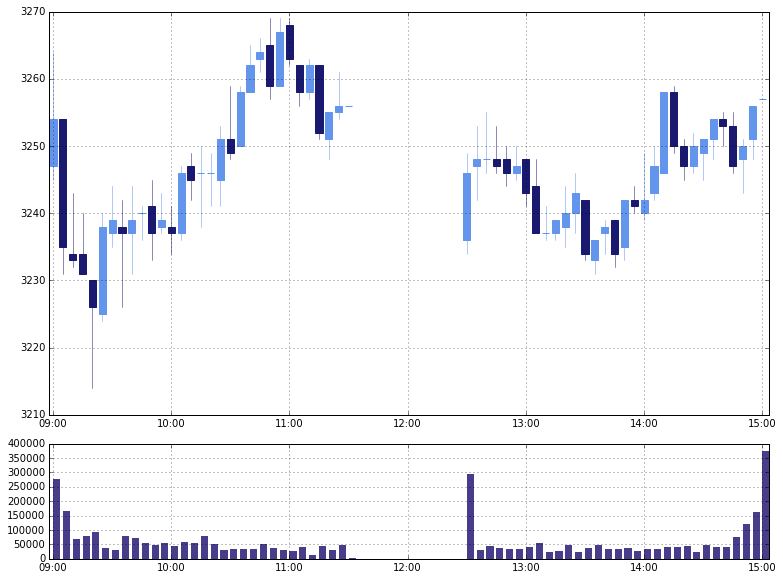

In [542]:
#株価の表示
#まずは日付をmatplotlibの関数を使ってmatplotlib内部の日時表記に変更する
#そのためにはpython標準のdatetimeにする必要がある。ここでawareにしたほうがよいかもしれない。があとでやるか
#いや、もう標準時での時間として処理してしまえばよい。ダウとかとデータが混ざらなければ、日本を絶対時間にしてもよい。かな？
import matplotlib.dates as md
import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from matplotlib.finance import candlestick_ohlc
import matplotlib.ticker as mticker

df_name = canon5min

pytime = [x.to_datetime() for x in df_name.index]
mpltime = [md.date2num(x) for x in pytime]
#次にohlc形式のリストを作ろう
ohlc = [(t, v[0],v[1],v[2],v[3]) for t, v in zip(mpltime, df_name.values)]

# dayFormatter = DateFormatter('%d')      # e.g., 12

# fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,12), sharex=True)
fig = plt.figure(figsize=(10,8))

ax1 = fig.add_axes((0, 0.25, 1, 0.7))
ax2 = fig.add_axes((0, 0, 1, 0.2), sharex=ax1)

# ax1 = fig.add_subplot(211)
# ax2 = fig.add_subplot(212, sharex = ax1)

# fig.subplots_adjust(bottom=0.2)

#昼休みをスキップするようなlocator必要かも。
# minute = md.MinuteLocator()
hour = md.HourLocator()
ax1.xaxis.set_major_locator(hour)
# ax.xaxis.set_major_locator(mticker.MaxNLocator(15))
#30分のラインも引きたいところだ.
#x軸の範囲はどうきめるのだろうか？
#引き渡してる値を使うのかも→その通り
#mpltimeを使って操作する
# ax.set_xlim( 736018.3819444445, 736018.625)

dayFormatter = md.DateFormatter('%H:%M')
ax1.xaxis.set_major_formatter(dayFormatter)

ax1.grid(True)

#ローソク足チャートを描画する
#太さを自動調整するように関数必要かもしれないな。
candlestick_ohlc(ax1, ohlc,width=0.0025,colorup='cornflowerblue', colordown='midnightblue')

ax1.xaxis.set_major_locator(hour)

dayFormatter = md.DateFormatter('%H:%M')
ax1.xaxis.set_major_formatter(dayFormatter)

ax1.grid(True)

ax2.bar(mpltime, df_name['volume'].values,width = 0.0025, color = 'darkslateblue', edgecolor='none')
ax2.xaxis.set_major_locator(hour)
ax2.xaxis.set_major_formatter(dayFormatter)
ax2.grid(True)


# ax.xaxis_date()
# ax.autoscale_view()
# plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
# plt.xlabel('Hour')
# plt.ylabel('Price')
# plt.title('ohlc chart')

plt.show()

In [492]:
v = toyota5min['volume']

In [536]:
v[:5]

2016-02-24 09:00:00    992400
2016-02-24 09:05:00    726600
2016-02-24 09:10:00    208400
2016-02-24 09:15:00    228900
2016-02-24 09:20:00    194700
Name: volume, dtype: float64

In [535]:
v.sum()

10888100.0

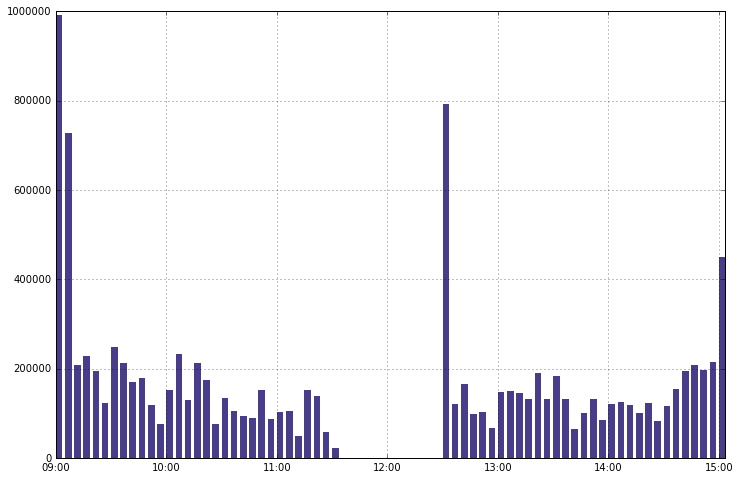

In [523]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

hour = md.HourLocator()
ax.xaxis.set_major_locator(hour)

dayFormatter = md.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(dayFormatter)

ax.grid(True)

ax.bar(mpltime, v.values,width = 0.0025, color = 'darkslateblue', edgecolor='none')
# ax.plot(v)


plt.show()

In [505]:
ax.bar?

In [495]:
toyota1min['open'].values.sum()

1793681.0

In [475]:
toyotaV = d20160224.get_volume(7203)

In [476]:
toyotaV.head()

,volume
2016-02-24 09:00:00,700300
2016-02-24 09:01:00,50300
2016-02-24 09:02:00,157000
2016-02-24 09:03:00,55400
2016-02-24 09:04:00,29400


In [467]:
df = toyotaV
v = df.values.flatten()
vd = np.append(v[0], v[1:] - v[:-1])
vdf = DataFrame(vd, index = df.index, columns=['volume'])

In [468]:
vdf

,volume
2016-02-24 09:00:00,700300
2016-02-24 09:01:00,50300
2016-02-24 09:02:00,157000
2016-02-24 09:03:00,55400
2016-02-24 09:04:00,29400
2016-02-24 09:05:00,166900
2016-02-24 09:06:00,235100
2016-02-24 09:07:00,143700
2016-02-24 09:08:00,86200
2016-02-24 09:09:00,94700


In [465]:
toyotaV.values.flatten()

array([  700300,   750600,   907600,   963000,   992400,  1159300,
        1394400,  1538100,  1624300,  1719000,  1778500,  1812000,
        1857300,  1883500,  1927400,  1976300,  2032800,  2074000,
        2102500,  2156300,  2197800,  2217800,  2237000,  2327600,
        2351000,  2377300,  2399700,  2432200,  2452400,  2473000,
        2527100,  2541100,  2604900,  2671800,  2721900,  2760200,
        2789200,  2812700,  2874900,  2934400,  2954300,  2996500,
        3024400,  3079400,  3105100,  3144300,  3153800,  3209200,
        3256000,  3284800,  3298400,  3314600,  3351000,  3384900,
        3404000,  3425200,  3434700,  3451300,  3468200,  3480400,
        3503300,  3527100,  3586000,  3601100,  3632700,  3747000,
        3774700,  3795800,  3813000,  3864400,  3925100,  3943000,
        3959400,  3972800,  3994900,  4056000,  4080400,  4148500,
        4177700,  4207600,  4226700,  4302700,  4342300,  4371100,
        4381900,  4398400,  4419700,  4432300,  4446500,  4456

In [443]:
toyota1min = d20160224.get_four_prices(7203)

In [445]:
toyota1min[1:].values

array([[ 5879.,  5899.,  5873.,  5893.],
       [ 5894.,  5919.,  5888.,  5903.],
       [ 5900.,  5900.,  5887.,  5889.],
       ..., 
       [ 5966.,  5966.,  5959.,  5962.],
       [ 5961.,  5974.,  5960.,  5974.],
       [ 5974.,  5974.,  5974.,  5974.]])

In [441]:
v.head()

2016-02-24 09:00:00    700300
2016-02-24 09:01:00    750600
2016-02-24 09:02:00    907600
2016-02-24 09:03:00    963000
2016-02-24 09:04:00    992400
Name: volume, dtype: int64

In [442]:
v = toyota1min['volume']

KeyError: 'volume'

In [455]:
type(v)

pandas.core.series.Series

In [426]:
v[0]

700300

In [427]:
#出来高が積算になっているので差分をとっておく
vd = np.append(np.array(v[0]), v[1:].values-v[:-1].values)
vdf = DataFrame(vd, index = v.index, columns=['volume'])

In [432]:
vdf = DataFrame(vd, index = v.index, columns=['volume'])

In [433]:
vdf

,volume
2016-02-24 09:00:00,700300
2016-02-24 09:01:00,50300
2016-02-24 09:02:00,157000
2016-02-24 09:03:00,55400
2016-02-24 09:04:00,29400
2016-02-24 09:05:00,166900
2016-02-24 09:06:00,235100
2016-02-24 09:07:00,143700
2016-02-24 09:08:00,86200
2016-02-24 09:09:00,94700


In [423]:
v[1:].values-v[:-1].values

array([ 50300, 157000,  55400,  29400, 166900, 235100, 143700,  86200,
        94700,  59500,  33500,  45300,  26200,  43900,  48900,  56500,
        41200,  28500,  53800,  41500,  20000,  19200,  90600,  23400,
        26300,  22400,  32500,  20200,  20600,  54100,  14000,  63800,
        66900,  50100,  38300,  29000,  23500,  62200,  59500,  19900,
        42200,  27900,  55000,  25700,  39200,   9500,  55400,  46800,
        28800,  13600,  16200,  36400,  33900,  19100,  21200,   9500,
        16600,  16900,  12200,  22900,  23800,  58900,  15100,  31600,
       114300,  27700,  21100,  17200,  51400,  60700,  17900,  16400,
        13400,  22100,  61100,  24400,  68100,  29200,  29900,  19100,
        76000,  39600,  28800,  10800,  16500,  21300,  12600,  14200,
        10200,  54800,  29100,  19900,  21300,   8600,  25400,  31000,
        16600,   6400,  25300,  21600,  15000,  28200,  10900,  17200,
        17300,  30400,  13900,  10900,  15700,  57900,  35200,  23300,
      

In [399]:
toyota5min = d20160224.get_four_prices_volume_5min(7203)

In [413]:
toyota5min[:10]

,open,high,low,close
2016-02-24 09:00:00,5900,5919,5873,5889
2016-02-24 09:05:00,5889,5889,5835,5850
2016-02-24 09:10:00,5848,5878,5841,5868
2016-02-24 09:15:00,5869,5875,5855,5861
2016-02-24 09:20:00,5862,5868,5852,5856
2016-02-24 09:25:00,5857,5869,5851,5863
2016-02-24 09:30:00,5863,5886,5860,5874
2016-02-24 09:35:00,5874,5884,5860,5878
2016-02-24 09:40:00,5878,5899,5873,5893
2016-02-24 09:45:00,5893,5908,5886,5904


In [408]:
mpltime

[736018.375,
 736018.3784722222,
 736018.3819444445,
 736018.3854166666,
 736018.3888888889,
 736018.3923611111,
 736018.3958333334,
 736018.3993055555,
 736018.4027777778,
 736018.40625,
 736018.4097222222,
 736018.4131944445,
 736018.4166666666,
 736018.4201388889,
 736018.4236111111,
 736018.4270833334,
 736018.4305555555,
 736018.4340277778,
 736018.4375,
 736018.4409722222,
 736018.4444444445,
 736018.4479166666,
 736018.4513888889,
 736018.4548611111,
 736018.4583333334,
 736018.4618055555,
 736018.4652777778,
 736018.46875,
 736018.4722222222,
 736018.4756944445,
 736018.4791666666,
 736018.5208333334,
 736018.5243055555,
 736018.5277777778,
 736018.53125,
 736018.5347222222,
 736018.5381944445,
 736018.5416666666,
 736018.5451388889,
 736018.5486111111,
 736018.5520833334,
 736018.5555555555,
 736018.5590277778,
 736018.5625,
 736018.5659722222,
 736018.5694444445,
 736018.5729166666,
 736018.5763888889,
 736018.5798611111,
 736018.5833333334,
 736018.5868055555,
 736018.590277

In [392]:
t[30:]

,open,high,low,close
2016-02-24 11:30:00,5968,5968,5968,5968
2016-02-24 12:30:00,5945,5957,5935,5950
2016-02-24 12:35:00,5949,5957,5947,5948
2016-02-24 12:40:00,5949,5971,5949,5965
2016-02-24 12:45:00,5966,5989,5965,5974
2016-02-24 12:50:00,5974,5980,5967,5970
2016-02-24 12:55:00,5971,5977,5968,5973
2016-02-24 13:00:00,5973,5973,5958,5964
2016-02-24 13:05:00,5964,5972,5959,5961
2016-02-24 13:10:00,5962,5966,5956,5959


In [371]:
pd.concat([t[0],t[1]])

,open,high,low,close
2016-02-24 09:00:00,5900,5919,5873,5890
2016-02-24 09:05:00,5889,5889,5835,5848
2016-02-24 09:10:00,5848,5878,5841,5875
2016-02-24 09:15:00,5869,5875,5855,5868
2016-02-24 09:20:00,5862,5868,5852,5858
2016-02-24 09:25:00,5857,5869,5851,5869
2016-02-24 09:30:00,5863,5886,5860,5881
2016-02-24 09:35:00,5874,5884,5860,5882
2016-02-24 09:40:00,5878,5899,5873,5889
2016-02-24 09:45:00,5893,5908,5886,5903


In [362]:
t

,0,1,2,3
2016-02-24 09:00:00,5900,5919,5873,5890
2016-02-24 09:05:00,5889,5889,5835,5848
2016-02-24 09:10:00,5848,5878,5841,5875
2016-02-24 09:15:00,5869,5875,5855,5868
2016-02-24 09:20:00,5862,5868,5852,5858
2016-02-24 09:25:00,5857,5869,5851,5869
2016-02-24 09:30:00,5863,5886,5860,5881
2016-02-24 09:35:00,5874,5884,5860,5882
2016-02-24 09:40:00,5878,5899,5873,5889
2016-02-24 09:45:00,5893,5908,5886,5903


In [352]:
ttt = tt.T

In [353]:
df1 = DataFrame(ttt)

In [354]:
df1.head()

,0,1,2,3
0,5900,5919,5873,5890
1,5889,5889,5835,5848
2,5848,5878,5841,5875
3,5869,5875,5855,5868
4,5862,5868,5852,5858


In [324]:
toyota.head(10)

,open,high,low,close,volume
2016-02-24 09:00:00,5900,5900,5877,5877,700300
2016-02-24 09:01:00,5879,5899,5873,5893,750600
2016-02-24 09:02:00,5894,5919,5888,5903,907600
2016-02-24 09:03:00,5900,5900,5887,5889,963000
2016-02-24 09:04:00,5890,5891,5883,5889,992400
2016-02-24 09:05:00,5889,5889,5866,5868,1159300
2016-02-24 09:06:00,5865,5867,5840,5845,1394400
2016-02-24 09:07:00,5847,5857,5835,5849,1538100
2016-02-24 09:08:00,5849,5857,5842,5850,1624300
2016-02-24 09:09:00,5848,5867,5844,5850,1719000


In [220]:
#まずindexの区切りをつけよう
#昼休みはどうしようかな
#ああ、9時と12時30分みつけたらいいのか
#これはさすがにどれもかわらないから、index指定でもよいのかな？　
#リスト内包でもいけそうかな？でも二つにわける必要があるのか。そうだな
toyota_open=toyota['open']
toyota_close=toyota['close']


In [301]:
#午前の引け11:30と午後の引けを特定する
min_class = d20160224
min_df = toyota
t1130 = pd.to_datetime(min_class.date + '1130') #タイムスタンプを作成する
time_series = min_df.index
t1130_index, = time_series.indexer_at_time(t1130) #1130のindexを特定.カンマはarrayから取り出している
#午後の引けを特定する.こっちは最後のデータのindexを探す
tClosed_index, = time_series.indexer_at_time(time_series[-1])

In [302]:
tClosed_index

301

In [303]:
time_series[tClosed_index]

Timestamp('2016-02-24 15:00:00')

In [306]:
ts = time_series[:t1130_index+1]

In [307]:
ts[::5]

DatetimeIndex(['2016-02-24 09:00:00', '2016-02-24 09:05:00',
               '2016-02-24 09:10:00', '2016-02-24 09:15:00',
               '2016-02-24 09:20:00', '2016-02-24 09:25:00',
               '2016-02-24 09:30:00', '2016-02-24 09:35:00',
               '2016-02-24 09:40:00', '2016-02-24 09:45:00',
               '2016-02-24 09:50:00', '2016-02-24 09:55:00',
               '2016-02-24 10:00:00', '2016-02-24 10:05:00',
               '2016-02-24 10:10:00', '2016-02-24 10:15:00',
               '2016-02-24 10:20:00', '2016-02-24 10:25:00',
               '2016-02-24 10:30:00', '2016-02-24 10:35:00',
               '2016-02-24 10:40:00', '2016-02-24 10:45:00',
               '2016-02-24 10:50:00', '2016-02-24 10:55:00',
               '2016-02-24 11:00:00', '2016-02-24 11:05:00',
               '2016-02-24 11:10:00', '2016-02-24 11:15:00',
               '2016-02-24 11:20:00', '2016-02-24 11:25:00',
               '2016-02-24 11:30:00'],
              dtype='datetime64[ns]', freq=Non

In [221]:
#午前と午後をわけている。正確にやるならtimestampからやったほうがよいか。
open_am = toyota_open.iloc[:151]
open_pm = toyota_open.iloc[151:]
close_am = toyota_open.iloc[:151]
close_pm = toyota_open.iloc[151:]

In [251]:
def detect_openclose_price(price_list):
    '''価格のリストのデータを入れて始値と終値を返す'''
    for  i in price_list:
        if np.isnan(i):
            price = np.nan
        else:
            return i
            break
        return price
# def detect_max_price(price_list):
    
opnp = np.array([])
clsp = np.array([])
minp = np.array([])
maxp = np.array([])

#午前と午後の分がある
def get_5min_price(df):
    '''dataframeを入力として5分足のためのデータを作る
    最初の1分の
    '''
    for i in np.arange(0,len(df), 5):
        #もし15時3分だったらどうするのか？エラーになる。。それいかんな。tryを使おう。
        #close priceはリストを逆順にしたらよい
        try:
            p = detect_openclose_price(open_am[i:i + 5])
            opnp = np.append(opnp, p)
            p = detect_openclose_price(close_am[i:i + 5][::-1]) #リストを逆にして入れる
            clsp = np.append(clsp, p)

            p = np.nanmin(close_am[i:i + 5]) 
            minp = np.append(minp, p)
            p = np.nanmax(close_am[i:i + 5]) #リストを逆にして入れる
            maxp = np.append(maxp, p)

        except:
            op = detect_openclose_price(open_am[i:])
            p = np.append(p, op)
    

In [222]:
open_am = open_am[1:]

In [223]:
open_am

2016-02-24 09:01:00    5879
2016-02-24 09:02:00    5894
2016-02-24 09:03:00    5900
2016-02-24 09:04:00    5890
2016-02-24 09:05:00    5889
2016-02-24 09:06:00    5865
2016-02-24 09:07:00    5847
2016-02-24 09:08:00    5849
2016-02-24 09:09:00    5848
2016-02-24 09:10:00    5848
2016-02-24 09:11:00    5862
2016-02-24 09:12:00    5865
2016-02-24 09:13:00    5872
2016-02-24 09:14:00    5875
2016-02-24 09:15:00    5869
2016-02-24 09:16:00    5866
2016-02-24 09:17:00    5859
2016-02-24 09:18:00    5871
2016-02-24 09:19:00    5868
2016-02-24 09:20:00    5862
2016-02-24 09:21:00    5860
2016-02-24 09:22:00    5864
2016-02-24 09:23:00    5861
2016-02-24 09:24:00    5858
2016-02-24 09:25:00    5857
2016-02-24 09:26:00    5854
2016-02-24 09:27:00    5854
2016-02-24 09:28:00    5862
2016-02-24 09:29:00    5869
2016-02-24 09:30:00    5863
                       ... 
2016-02-24 11:01:00    5964
2016-02-24 11:02:00    5963
2016-02-24 11:03:00    5958
2016-02-24 11:04:00    5949
2016-02-24 11:05:00 

In [279]:
#
tes.iloc[150]

open         2424.5
high         2424.5
low          2424.5
close        2424.5
volume    4827500.0
Name: 2016-02-24 11:30:00, dtype: float64

In [256]:
close_am[1:6]

2016-02-24 09:01:00    5879
2016-02-24 09:02:00    5894
2016-02-24 09:03:00    5900
2016-02-24 09:04:00    5890
2016-02-24 09:05:00    5889
Name: open, dtype: float64

In [261]:
np.nanmin(close_am[1:6].values) 

5879.0

In [254]:
minp

array([ 5879.,  5879.,  5879.,  5879.,  5879.,  5847.,  5847.,  5847.,
        5847.,  5847.,  5848.,  5848.,  5848.,  5848.,  5848.,  5859.,
        5859.,  5859.,  5859.,  5859.,  5858.,  5858.,  5858.,  5858.,
        5858.,  5854.,  5854.,  5854.,  5854.,  5854.,  5863.,  5863.,
        5863.,  5863.,  5863.,  5866.,  5866.,  5866.,  5866.,  5866.,
        5878.,  5878.,  5878.,  5878.,  5878.,  5888.,  5888.,  5888.,
        5888.,  5888.,  5892.,  5892.,  5892.,  5892.,  5892.,  5889.,
        5889.,  5889.,  5889.,  5889.,  5887.,  5887.,  5887.,  5887.,
        5887.,  5902.,  5902.,  5902.,  5902.,  5902.,  5934.,  5934.,
        5934.,  5934.,  5934.,  5926.,  5926.,  5926.,  5926.,  5926.,
        5916.,  5916.,  5916.,  5916.,  5916.,  5914.,  5914.,  5914.,
        5914.,  5914.,  5917.,  5917.,  5917.,  5917.,  5917.,  5920.,
        5920.,  5920.,  5920.,  5920.,  5925.,  5925.,  5925.,  5925.,
        5925.,  5928.,  5928.,  5928.,  5928.,  5928.,  5938.,  5938.,
      

In [238]:
open_am.index[::5]

DatetimeIndex(['2016-02-24 09:01:00', '2016-02-24 09:06:00',
               '2016-02-24 09:11:00', '2016-02-24 09:16:00',
               '2016-02-24 09:21:00', '2016-02-24 09:26:00',
               '2016-02-24 09:31:00', '2016-02-24 09:36:00',
               '2016-02-24 09:41:00', '2016-02-24 09:46:00',
               '2016-02-24 09:51:00', '2016-02-24 09:56:00',
               '2016-02-24 10:01:00', '2016-02-24 10:06:00',
               '2016-02-24 10:11:00', '2016-02-24 10:16:00',
               '2016-02-24 10:21:00', '2016-02-24 10:26:00',
               '2016-02-24 10:31:00', '2016-02-24 10:36:00',
               '2016-02-24 10:41:00', '2016-02-24 10:46:00',
               '2016-02-24 10:51:00', '2016-02-24 10:56:00',
               '2016-02-24 11:01:00', '2016-02-24 11:06:00',
               '2016-02-24 11:11:00', '2016-02-24 11:16:00',
               '2016-02-24 11:21:00', '2016-02-24 11:26:00'],
              dtype='datetime64[ns]', freq=None)

In [235]:
for i in open_am[1:5]:
    print(i)

5894.0
5900.0
5890.0
5889.0


In [232]:
p[::-1]

array([ 5954.,  5947.,  5949.,  5948.,  5950.,  5964.,  5959.,  5951.,
        5930.,  5930.,  5929.,  5930.,  5914.,  5924.,  5935.,  5950.,
        5933.,  5891.,  5889.,  5908.,  5896.,  5879.,  5873.,  5866.,
        5854.,  5860.,  5866.,  5862.,  5865.,  5879.])

In [248]:
a = np.array([np.nan, np.nan,np.nan])

In [246]:
a.nanmin

AttributeError: 'numpy.ndarray' object has no attribute 'nanmin'

In [250]:
np.nanmax(a)

/Users/prokapi/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:326: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)


nan

In [209]:
a[::-1]

array([  34.,  123.,   nan])

In [201]:
np.isnan(b)

True

In [152]:
t = open_am.index[1]

In [155]:
t.time()

datetime.time(9, 1)

In [159]:
pd.to_datetime('{} 1005')

'Wed Feb 24 09:01:00 2016'

In [144]:
#あまりスマートでないな・・・・終値はこれから4分ずらせばよいだけかな
open_price_am_first = open_am.head(1)
open_price_am = open_am.iloc[1::5]
open_price_pm_first = open_pm.head(1)
open_price_pm = open_pm.iloc[1::5]
open_price  = pd.concat([open_price_am_first, open_price_am, open_price_pm_first, open_price_pm])

In [216]:
len(open_am)

151

In [219]:
np.arange(0,150,5)

array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
        65,  70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125,
       130, 135, 140, 145])

In [ ]:
open

In [218]:
np.arange?

In [215]:
open_am[1:6].values

array([ 5879.,  5894.,  5900.,  5890.,  5889.])

In [214]:
open_am[6:11]

2016-02-24 09:06:00    5865
2016-02-24 09:07:00    5847
2016-02-24 09:08:00    5849
2016-02-24 09:09:00    5848
2016-02-24 09:10:00    5848
Name: open, dtype: float64

In [148]:
close_price_am_first = close_am.head(1)
close_price_am = close_am.iloc[5::5]
close_price_pm_first = close_pm.head(1)
close_price_pm = close_pm.iloc[5::5]
close_price  = pd.concat([close_price_am_first, close_price_am, close_price_pm_first, close_price_pm])

In [149]:
close_price[:31]

2016-02-24 09:00:00    5900
2016-02-24 09:05:00    5889
2016-02-24 09:10:00    5848
2016-02-24 09:15:00    5869
2016-02-24 09:20:00    5862
2016-02-24 09:25:00    5857
2016-02-24 09:30:00    5863
2016-02-24 09:35:00    5874
2016-02-24 09:40:00    5878
2016-02-24 09:45:00    5893
2016-02-24 09:50:00    5904
2016-02-24 09:55:00    5889
2016-02-24 10:00:00    5894
2016-02-24 10:05:00    5902
2016-02-24 10:10:00    5941
2016-02-24 10:15:00    5940
2016-02-24 10:20:00    5934
2016-02-24 10:25:00    5920
2016-02-24 10:30:00    5919
2016-02-24 10:35:00    5920
2016-02-24 10:40:00    5926
2016-02-24 10:45:00    5928
2016-02-24 10:50:00    5938
2016-02-24 10:55:00    5950
2016-02-24 11:00:00    5963
2016-02-24 11:05:00    5950
2016-02-24 11:10:00    5948
2016-02-24 11:15:00    5956
2016-02-24 11:20:00    5948
2016-02-24 11:25:00    5951
2016-02-24 11:30:00    5968
Name: open, dtype: float64

In [96]:
tes.data_num_lis[:10]

[302, 302, 302, 302, 302, 302, 302, 302, 302, 302]

In [102]:
toyota = tes.get_four_prices_volume(7203)

In [104]:
toyota.iloc[150]

open         5968
high         5968
low          5968
close        5968
volume    5745900
Name: 2016-02-24 11:30:00, dtype: float64

In [2]:
#まずはファイルの読み込み
#目標は、銘柄コードを入れると、その銘柄のデータをdataframeにして返す関数
#まず、銘柄コードの場所を特定してみよう
#データの本数は必ず302本なのだろうか？？そこがずれるとだめなんだけど。
#ん？まずはデータの本数だけを拾っていくべきなんだな。
#それをやってみよう
#データの量がかなり多いから、numpyにした方がよいかもしれない。
# np.loadtxt(filename,delimiter='\t')

filename = '/Users/prokapi/iPythonNotebook_file/20160224_min20160224s.txt'
with open(filename, 'r',encoding='EUC-JP') as a_file:
    fr = a_file.readlines()

In [3]:
#最初に日付を取得する。ファイル名でもついてるけど、一応中から取得。
date = fr[0].split('\t')[0]
#各銘柄のヘッダー情報と、株価情報にわける。さらに株価情報は時間と、4本値と出来高を分ける。
#ヘッダー情報はそこから銘柄コードとデータ数と小数点数に分ける
#一列のデータが7個と4本値のデータが1個になる。あとは日付か。
header = []
time_series = []
four_values_lis = []
volume_lis = []
time_lis = []

#欠損値がハイフンになっているので、それをnp.nanに変換するための関数
n = np.nan
def f(x):
    if x == '-':
        return n
    else:
        return int(x)

for i in fr[1:]: #日付のデータを除いてる
    split = i.split('\t')
    header.append(split[:3]) #最初の3つのデータは、銘柄コード・データ本数・小数点
    p = split[3:] #それ以降が、時間と4本値と出来高の6セットが9時から15時まで続くデータ
    time_lis.append(p[::6][:-1])
    ary = range(len(p))
    four_values = [p[x] for x in ary if  (x % 6 != 0) and (x % 6 != 5)] #時間と出来高を除く
    four_values =np.array(list(map(f,four_values))) #欠損値をnp.nanにして、価格をintにする
    four_values_lis.append(four_values)
#     four_values_lis = np.append(four_values_lis, four_values)
    volume = [p[x] for x in ary if x % 6 == 5]
    volume =np.array(list(map(f,volume))) 
    volume_lis.append(volume) 

#ヘッダーから銘柄コードと、データ数と、小数点を抽出
stock_code_lis = [x[0] for x in header]
stock_code_lis = [int(x) for x in stock_code_lis] #文字列から整数型にしておく
data_num_lis = [int(x[1]) for x in header]
decimal_lis = [int(x[2]) for x in header]


In [41]:
#銘柄コードを入れると、時刻データ、株価、出来高のリストを返す関数を作る
def get_time_series(stock_code):
    try:
        index = stock_code_lis.index(stock_code)
        t = time_lis[index]
        t = [date + x for x in t] #日付を付け足しておく。dateは一番最初に取得してある日付。
        dt = pd.to_datetime(t) #pandasのtimestampオブジェクトに変換する
        return dt
    except:
        print('Your code is not in the list.')
def get_volume(stock_code):
    try:
        index = stock_code_lis.index(stock_code)
        volume = volume_lis[index]
        #時系列の取得
        time_stamps = get_time_series(stock_code)
        #pandasデータフレームに変換する
        df = pd.DataFrame(volume, index=time_stamps, columns=['volume'])
        return df
    except:
        print('Your code is not in the list.')
def get_four_prices(stock_code):
    try:
        index = stock_code_lis.index(stock_code)
        print('for price, index is {}'.format(index))
        data_num = data_num_lis[index]
        #小数点合わせる #厳密にやるならdecimalを使う必要があるが、、numpyでは扱えないのでやめる
        #だから差分を比較するとかするときは注意が必要！地雷になりませんように。。
        four_prices = four_values_lis[index] /10**decimal_lis[index]
#         print(decimal_lis[index])
        #2次元配列に変える
        four_prices.shape = (four_prices.size//4, 4)
        #時系列の取得
        time_stamps = get_time_series(stock_code)
        #pandasデータフレームに変換する
        df = pd.DataFrame(four_prices, index=time_stamps, columns=['open','high','low','close'])
#         print(four_prices.size)
#         print(data_num)
#         print(len(four_prices))
        if len(df) == data_num: #データの数が合っているかチェックする
            return df
        else:
            return print('data_num error')
    except:
        print('Your code is not in the list.')

def get_four_prices_volume(stock_code):
    price_df = get_four_prices(stock_code)
    volume_df = get_volume(stock_code)
    df = pd.concat([price_df, volume_df], axis=1)
    return df

In [50]:
#株価の取得
stock_code = 7203
df1 = get_four_prices_volume(stock_code)

for price, index is 1989


In [ ]:
#ここまででクラスなどにまとめることにしよう
#5分足にまとめてもよいかもしれないな。。
#ローソク足で1日分を1分で表示するのはかなり無理ある。

In [393]:
#株価の表示
#まずは日付をmatplotlibの関数を使ってmatplotlib内部の日時表記に変更する
#そのためにはpython標準のdatetimeにする必要がある。ここでawareにしたほうがよいかもしれない。があとでやるか
#いや、もう標準時での時間として処理してしまえばよい。ダウとかとデータが混ざらなければ、日本を絶対時間にしてもよい。かな？
import matplotlib.dates as md
import datetime
df_name = t

pytime = [x.to_datetime() for x in df_name.index]
mpltime = [md.date2num(x) for x in pytime]
#次にohlc形式のリストを作ろう
ohlc = [(t, v[0],v[1],v[2],v[3]) for t, v in zip(mpltime, df_name.values)]


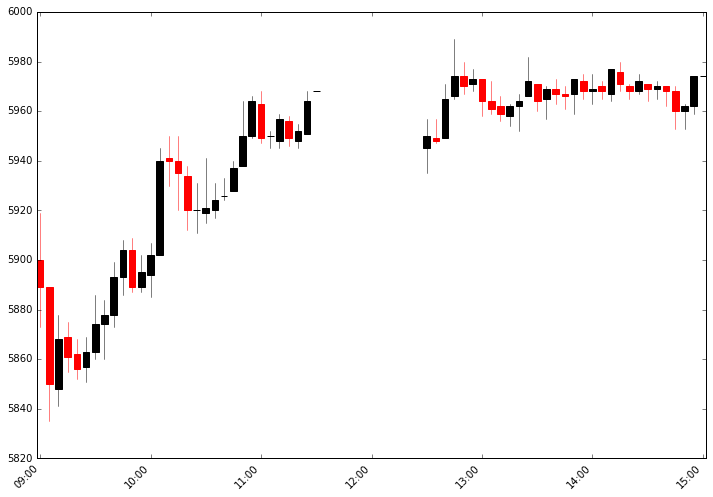

In [397]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from matplotlib.finance import candlestick_ohlc

# dayFormatter = DateFormatter('%d')      # e.g., 12
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
# fig.subplots_adjust(bottom=0.2)

# minute = md.MinuteLocator()
hour = md.HourLocator()
ax.xaxis.set_major_locator(hour)

dayFormatter = md.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(dayFormatter)


# ax.xaxis.set_minor_locator(alldays)
#ax.xaxis.set_minor_formatter(dayFormatter)
#plot_day_summary(ax, quotes, ticksize=3)

candlestick_ohlc(ax, ohlc,width=0.0025)

# ax.xaxis_date()
# ax.autoscale_view()
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')

plt.show()

In [53]:
ohlc[:10]

[(736018.375, 5900.0, 5900.0, 5877.0, 5877.0),
 (736018.3756944444, 5879.0, 5899.0, 5873.0, 5893.0),
 (736018.3763888889, 5894.0, 5919.0, 5888.0, 5903.0),
 (736018.3770833333, 5900.0, 5900.0, 5887.0, 5889.0),
 (736018.3777777777, 5890.0, 5891.0, 5883.0, 5889.0),
 (736018.3784722222, 5889.0, 5889.0, 5866.0, 5868.0),
 (736018.3791666667, 5865.0, 5867.0, 5840.0, 5845.0),
 (736018.379861111, 5847.0, 5857.0, 5835.0, 5849.0),
 (736018.3805555556, 5849.0, 5857.0, 5842.0, 5850.0),
 (736018.38125, 5848.0, 5867.0, 5844.0, 5850.0)]

In [51]:
df1.head()

,open,high,low,close,volume
2016-02-24 09:00:00,5900,5900,5877,5877,700300
2016-02-24 09:01:00,5879,5899,5873,5893,750600
2016-02-24 09:02:00,5894,5919,5888,5903,907600
2016-02-24 09:03:00,5900,5900,5887,5889,963000
2016-02-24 09:04:00,5890,5891,5883,5889,992400


In [109]:
df1 = pd.DataFrame(p, index=t, columns=['Open','High','Low','Close'])

In [110]:
df2 = pd.DataFrame(v, index=t, columns=['Volume'])

In [111]:
df1.head()

,Open,High,Low,Close
2016-02-24 09:00:00,15851.13,15852.48,15851.13,15852.48
2016-02-24 09:01:00,15848.42,15848.42,15839.79,15839.79
2016-02-24 09:02:00,15851.62,15862.06,15851.62,15862.06
2016-02-24 09:03:00,15859.28,15859.28,15817.79,15817.79
2016-02-24 09:04:00,15820.66,15824.78,15819.99,15819.99


In [5]:
#時系列データの作成
#それっぽい形でデータを渡すと、timestampオブジェクトに変換してくれるらしい。超便利!!
dt = pd.to_datetime('2014-11-09 10:00')
print(dt)
print(type(dt))

import datetime
print(isinstance(dt, datetime.datetime))

2014-11-09 10:00:00
<class 'pandas.tslib.Timestamp'>
True


In [112]:
df2.head()

,Volume
2016-02-24 09:00:00,1149340
2016-02-24 09:01:00,1252660
2016-02-24 09:02:00,1347849
2016-02-24 09:03:00,1712882
2016-02-24 09:04:00,1835898


In [114]:
result = pd.concat([df1, df2], axis=1)

In [115]:
result.head()

,Open,High,Low,Close,Volume
2016-02-24 09:00:00,15851.13,15852.48,15851.13,15852.48,1149340
2016-02-24 09:01:00,15848.42,15848.42,15839.79,15839.79,1252660
2016-02-24 09:02:00,15851.62,15862.06,15851.62,15862.06,1347849
2016-02-24 09:03:00,15859.28,15859.28,15817.79,15817.79,1712882
2016-02-24 09:04:00,15820.66,15824.78,15819.99,15819.99,1835898


In [117]:
result.index

DatetimeIndex(['2016-02-24 09:00:00', '2016-02-24 09:01:00',
               '2016-02-24 09:02:00', '2016-02-24 09:03:00',
               '2016-02-24 09:04:00', '2016-02-24 09:05:00',
               '2016-02-24 09:06:00', '2016-02-24 09:07:00',
               '2016-02-24 09:08:00', '2016-02-24 09:09:00',
               ...
               '2016-02-24 14:51:00', '2016-02-24 14:52:00',
               '2016-02-24 14:53:00', '2016-02-24 14:54:00',
               '2016-02-24 14:55:00', '2016-02-24 14:56:00',
               '2016-02-24 14:57:00', '2016-02-24 14:58:00',
               '2016-02-24 14:59:00', '2016-02-24 15:00:00'],
              dtype='datetime64[ns]', length=302, freq=None)

In [383]:
#まずは日付をmatplotlibの関数を使ってmatplotlib内部の日時表記に変更する
#そのためにはpython標準のdatetimeにする必要がある。ここでawareにしたほうがよいかもしれない。があとでやるか
import matplotlib.dates as md
import datetime
# matplotlib.dates.date2num(d)
pytime = [x.to_datetime() for x in result.index]
mpltime = [md.date2num(x) for x in pytime]


In [387]:
#次にohlc形式のリストを作ろう
ohlc = [(t, v[0],v[1],v[2],v[3]) for t, v in zip(mpltime, result.values)]


In [ ]:
#次にlocaterとfomatterをせいびする

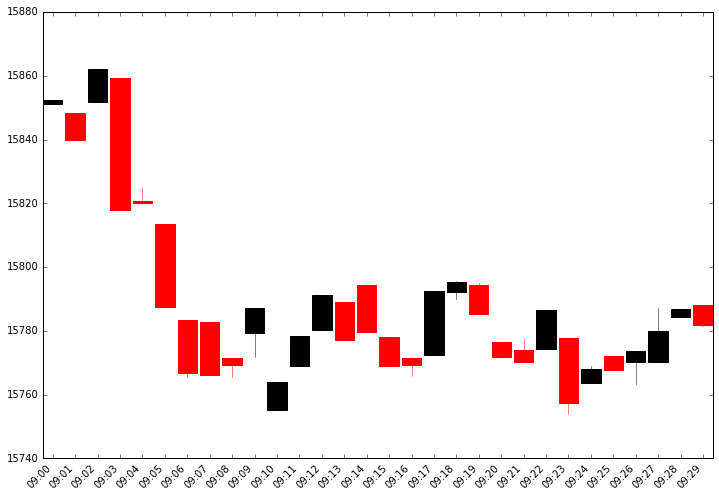

In [411]:
#とりあえず表示
#これからやればよかったーーー公式あたるべき
#http://matplotlib.org/examples/pylab_examples/finance_demo.html

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from matplotlib.finance import candlestick_ohlc

# dayFormatter = DateFormatter('%d')      # e.g., 12
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
# fig.subplots_adjust(bottom=0.2)

minute = md.MinuteLocator()
ax.xaxis.set_major_locator(minute)

dayFormatter = md.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(dayFormatter)


# ax.xaxis.set_minor_locator(alldays)
#ax.xaxis.set_minor_formatter(dayFormatter)
#plot_day_summary(ax, quotes, ticksize=3)

candlestick_ohlc(ax, ohlc[:30],width=0.0006)

# ax.xaxis_date()
# ax.autoscale_view()
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')

plt.show()